In [43]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)


## Generative process class

In [44]:
class GP:

    def __init__(self, dt, omega2_GP=0.5, alpha=[1.,1.]):

        # Harmonic oscillator angular frequency (both x_0 and x_2)
        self.omega2 = omega2_GP
        # Variable representing the central pattern generator
        self.cpg = np.array([0., 1.])
        # Parameter that regulates whiskers amplitude oscillation
        self.a = np.array(alpha)
        # Whiskers base angles
        self.x = np.zeros(len(self.a))
        # Array storing proprioceptive sensory inputs (whiskers angular velocity)
        self.s_p = np.ones(len(self.a))*(self.a*self.cpg[0]-self.x)
        # Array storing touch sensory inputs
        self.s_t = np.zeros(len(self.a))
        # Variance of the Gaussian noise that gives proprioceptive sensory inputs
        self.Sigma_s_p = np.ones(len(self.a))*0.05
        # Variance of the Gaussian noise that gives touch sensort inputs
        self.Sigma_s_t = np.ones(len(self.a))*0.
        # Size of a simulation step
        self.dt = dt
        # Time variable
        self.t = 0.
        # Time interval in which the object appears
        self.object_interval = [25, 90]
        # Object position (when is present)
        self.object_position = np.array([0.5, 0.5])

    # Function that regulates object position
    def obj_pos(self, t, obj_interval):
        if t > obj_interval[0] and t < obj_interval[1]:
            return self.object_position
        else:
            return np.array([10., 10.])


    # Discrete function that return if a whisker has touched
    def touch(self, x, object):
        if x>=object:
            return 1.
        else:
            return 0.

    # Continuous function that return if a whisker has touched
    def touch_cont(self, x, platform_position, prec=100):
        return 0.5 * (np.tanh(prec*(x-platform_position)) + 1)

    # Function that implement dynamics of the process.
    def update(self, action):
        # Action argument (double) is the variable that comes from the GM that modifies alpha
        # variable affecting the amplitude of the oscillation.

        # Increment of time variable
        self.t += self.dt
        # Increment of alpha variable (that changes the amplitude) given by agent's action
        self.a += action
        # GP dynamics implementation
        self.cpg[0] += self.dt*(self.cpg[1])
        self.cpg[1] += self.dt*(-self.omega2*self.cpg[0])
        self.x += self.dt*(self.a*self.cpg[0] - self.x)


        # object Action on touch sensory inputs
        for i in range(len(self.x)):
            self.effective_object_position = self.obj_pos(self.t, self.object_interval)
            self.s_t[i] = self.touch_cont(self.x[i], self.effective_object_position[i]) + self.Sigma_s_t[i]*rng.randn()
            if self.x[i] > self.effective_object_position[i]:
                self.x[i] = min(self.x[i], self.effective_object_position[i])
                self.s_p[i] = 0 # self.a[i]*self.cpg[0] - self.x[i]
            else:
                self.s_p[i] = self.a[i]*self.cpg[0] - self.x[i]
            self.s_p[i] += self.Sigma_s_p[i]*rng.randn()

## Generative model class

In [45]:
class GM:

    def __init__(self, dt, eta=0.001, eta_d=1., eta_a=0.06, eta_nu=0.01, nu=[1., 1.]):

        # Parameter that regulates whiskers amplitude oscillation
        self.nu = np.array(nu)
        # Vector \vec{\mu} initialized with the GP initial conditions
        self.mu = np.zeros(len(nu))
        # Vector \dot{\vec{\mu}}
        self.dmu = np.zeros(len(nu))
        # Variances (inverse of precisions) of sensory proprioceptive inputs
        self.Sigma_s_p = np.ones(len(nu))*0.01
        # Variances (inverse of precisions) of sensory touch inputs
        self.Sigma_s_t = np.ones(len(nu))*0.032 #np.array(Sigma_s_t)
        # Internal variables precisions
        self.Sigma_mu = np.ones(len(nu))*0.01 #np.array(Sigma_mu)

        # Action variable (in this case the action is intended as the increment of the variable that the agent is allowed to modified)
        self.da = 0.
        # Size of a simulation step
        self.dt = dt
        # Gradient descent weights
        self.eta = eta
        self.eta_d = eta_d
        self.eta_a = eta_a
        self.eta_nu = eta_nu

    # Touch function
    def g_touch(self, x, v, prec=50):
        return 1/np.cosh(prec*v)*(0.5*np.tanh(prec*x)+0.5)

    # Derivative of the touch function with respect to v
    def dg_dv(self, x, v, prec=50):
        return -prec*1/np.cosh(prec*v)*np.tanh(prec*v)*(0.5 * np.tanh(prec*x) + 0.5)

    # Derivative of the touch function with respect to x
    def dg_dx(self, x, v, prec=50):
        return 1/np.cosh(prec*v)*0.5*prec*(1/np.cosh(prec*x))**2


    # Function that implement the update of internal variables.
    def update(self, touch_sensory_states, proprioceptive_sensory_states, x):
        # touch_sensory_states  and proprioceptive_sensory_states arguments come from GP (both arrays have dimension equal to the number of whiskers)
        # Returns action increment


        self.s_p = proprioceptive_sensory_states
        self.s_t = touch_sensory_states

        self.PE_mu = self.dmu - (self.nu*x - self.mu)
        self.PE_s_p = self.s_p-self.dmu
        self.PE_s_t = self.s_t-self.g_touch(x=self.mu, v=self.dmu)

        self.dF_dmu = self.PE_mu/self.Sigma_mu \
                    - self.dg_dx(x=self.mu, v=self.dmu)*self.PE_s_t/self.Sigma_s_t

        self.dF_d_dmu = self.PE_mu/self.Sigma_mu \
                        - self.PE_s_p/self.Sigma_s_p \
                        - self.dg_dv(x=self.mu, v=self.dmu)*self.PE_s_t/self.Sigma_s_t

        # Action update
        # case with dg/da = 1
        self.da = -self.dt*self.eta_a*( x*self.PE_s_p/self.Sigma_s_p + self.PE_s_t/self.Sigma_s_t )

        # Learning internal parameter nu
        self.nu += -self.dt*self.eta_nu*(-x*self.PE_mu/self.Sigma_mu)

        self.mu += self.dt*(self.dmu - self.eta*self.dF_dmu)
        self.dmu += -self.dt*self.eta_d*self.dF_d_dmu

        return self.da

# Main

In [46]:
if __name__ == "__main__":
    dt = 0.005
    n_steps = 25000
    gp = GP(dt=dt, omega2_GP=0.5, alpha=[1., 0.3])
    gm = GM(dt=dt, eta=0.001, eta_d=1., eta_a=0.02, eta_nu=0.02, nu=gp.a)

    cpg = []
    obj_position = []

    gp_x = []
    gp_alpha = []

    sensory_state = []

    gm_mu = []
    gm_dmu = []
    gm_nu = []
    
    gm_PE_s_p = []
    gm_PE_s_t = []
    
    action = []

    for step in np.arange(n_steps):

        sensory_state.append([gp.s_p[0], gp.s_t[0]])

        action.append(gm.update(touch_sensory_states=gp.s_t, proprioceptive_sensory_states=gp.s_p, x=gp.cpg[0]))
        gp.update(action[-1])
        
        
        
        cpg.append( gp.cpg[0] )
        obj_position.append( [gp.effective_object_position[0], gp.effective_object_position[1]] )
        
        gp_x.append( [gp.x[0], gp.x[1]] )
        gp_alpha.append( [gp.a[0], gp.a[1]] )

        gm_mu.append( [gm.mu[0], gm.mu[1]] )
        gm_dmu.append( [gm.dmu[0], gm.dmu[1]] )
        gm_nu.append( [gm.nu[0], gm.nu[1]] )
        
        gm_PE_s_p.append( [gm.PE_s_p[0], gm.PE_s_p[1]] )
        gm_PE_s_t.append( [gm.PE_s_t[0], gm.PE_s_t[1]] )

    action = np.vstack(action)
    sensory_state = np.vstack(sensory_state)
    obj_position = np.vstack(obj_position)

    gp_x = np.vstack(gp_x)
    gp_alpha = np.vstack(gp_alpha)

    gm_mu = np.vstack(gm_mu)
    gm_dmu = np.vstack(gm_dmu)
    gm_nu = np.vstack(gm_nu)
    gm_PE_s_p = np.vstack(gm_PE_s_p)
    gm_PE_s_t = np.vstack(gm_PE_s_t)
    
    time = np.arange(0, n_steps*dt, dt)
    platform_interval = np.arange(gp.object_interval[0], gp.object_interval[1], dt)
    

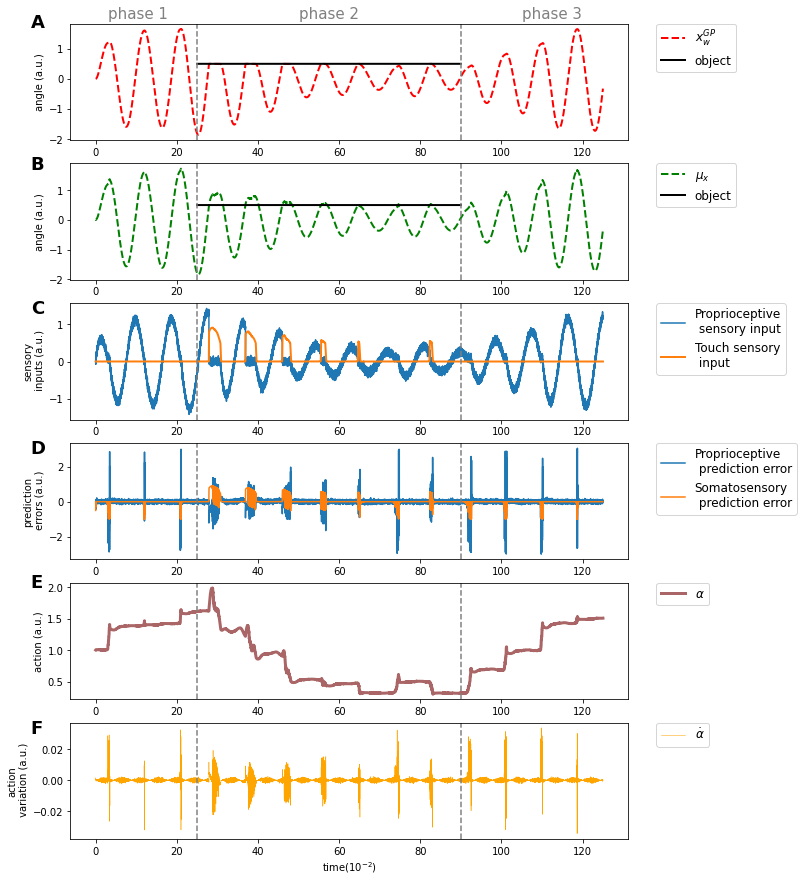

In [52]:
    # Create single whisker figure
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize = (10,15))

    # Add subplots
    ax1.text(3, 2, "phase 1", c="grey", fontsize=15)
    ax1.text(50, 2, "phase 2", c="grey", fontsize=15)
    ax1.text(105, 2, "phase 3", c="grey", fontsize=15)
    ax1.plot(time, gp_x[:,0], c="red", lw=2, ls="dashed", label=r"$x_w^{GP}$")
    ax1.plot(platform_interval, np.ones(len(platform_interval))*gp.object_position[0], c="black",lw=2, label=r"object")
    ax1.axvline(x=25., ls="--", c="grey")
    ax1.axvline(x=90., ls="--", c="grey")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax1.set_ylabel("angle (a.u.)")
    ax1.text( -16., 1.7, "A", size=18, weight='bold' )
    
    ax2.plot(time, gm_mu[:,0], c="green", lw=2, ls="dashed", label=r"$\mu_x$")
    ax2.plot(platform_interval, np.ones(len(platform_interval))*gp.object_position[0], c="black",lw=2, label=r"object")
    ax2.axvline(x=25., ls="--", c="grey")
    ax2.axvline(x=90., ls="--", c="grey")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax2.set_ylabel("angle (a.u.)")
    ax2.text( -16., 1.7, "B", size=18, weight='bold' )
    
    ax3.plot(time, sensory_state[:,0], label="Proprioceptive\n sensory input")
    ax3.plot(time, sensory_state[:,1], lw=2, label="Touch sensory\n input")
    ax3.axvline(x=25., ls="--", c="grey")
    ax3.axvline(x=90., ls="--", c="grey")
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax3.set_ylabel("sensory\n inputs (a.u.)")
    ax3.text( -16., 1.3, "C", size=18, weight='bold' )
    
    ax4.plot(time, gm_PE_s_p[:,0], label="Proprioceptive\n prediction error")
    ax4.plot(time, gm_PE_s_t[:,0], label="Somatosensory\n prediction error")
    ax4.axvline(x=25., ls="--", c="grey")
    ax4.axvline(x=90., ls="--", c="grey")
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax4.set_ylabel("prediction\n errors (a.u.)")
    ax4.text( -16., 2.8, "D", size=18, weight='bold' )
    
    ax5.plot(time, gp_alpha[:,0], c="#aa6666", lw=3, label=r"$\alpha$")
    ax5.axvline(x=25., ls="--", c="grey")
    ax5.axvline(x=90., ls="--", c="grey")
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax5.set_ylabel("action (a.u.)")
    ax5.text( -16., 2., "E", size=18, weight='bold' )
    
    ax6.plot(time, action[:,0], lw=0.5, c="orange", label=r"$\dot{\alpha}$")
    ax6.axvline(x=25., ls="--", c="grey")
    ax6.axvline(x=90., ls="--", c="grey")
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax6.set_ylabel("action\n variation (a.u.)")
    ax6.set_xlabel("time($10^{-2}$)")
    ax6.text( -16., 0.03, "F", size=18, weight='bold' )
            
    plt.show()

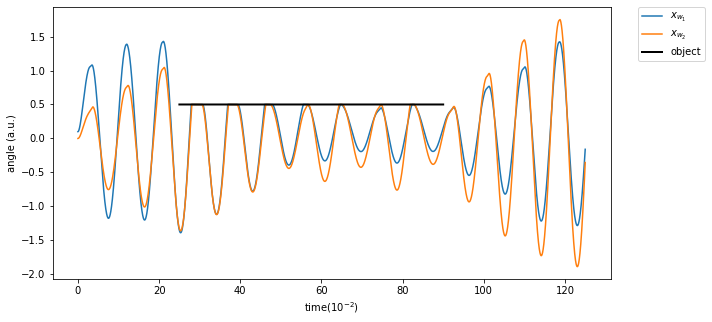

In [49]:
    # Double whiskers figure
    plt.figure(figsize=(10, 5))
    plt.plot(time, gp_x[:,0]*0.8+0.5*0.2, label=r"$x_{w_1}$")
    plt.plot(time, gp_x[:,1], label=r"$x_{w_2}$")
    plt.plot(platform_interval, np.ones(len(platform_interval))*gp.object_position[0], c="black",lw=2, label=r"object")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylabel("angle (a.u.)")
    plt.xlabel("time($10^{-2}$)")
    plt.show()